## Classifying The Brain on Music

\## Author: Michael Maddison  
\## Collaborators: Lindsay Harris


In this project, I classify fMRI brain images taken while listening to music in five different genres with labels:  
&ensp;    *0=Ambient Music,        3=Rock 'n Roll*    
&ensp;    *1=Country Music,        4=Classical Symphonic.*     
&ensp;    *2=Heavy Metal,*  


**Training Data** consist of 160 event-related brain images (trials), corresponding to twenty 6-second music clips, four clips in each of the five genres, repeated in-order eight times (runs).  
- Each brain image has 22036 features, corresponding to blood-oxygenation levels at each 2mm-cubed 3D location within a section of the auditory cortex.

**Testing data** consists of 40 event-related brain images corresponding to novel 6-second music clips in the five genres. The test data is in randomized order with no labels.


## Data Download

In [1]:
import numpy as np
#!pip install gdown

In [2]:
# !gdown --id 1aFDPryEDcT5wg0k8NhWYpF8lulGmot5J # train data
# !gdown --id 11kgAdB_hkEcC4npCEWJcAOOmGe3495yY # train labels
# !gdown --id 1wXq56F6RIUtDzPceZegZAMA-JGW21Gqu # test data

In [3]:
# Data Import: Read the data into memory using python's built-in CSV parser
import csv

with open('train_data.csv', 'r') as csvfile:
  train_data = np.array([row for row in csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)])
with open('train_labels.csv', 'r') as csvfile:
  train_labels = np.array( [row for row in csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)] )
with open('test_data.csv', 'r') as csvfile:
  test_data = np.array( [row for row in csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)] )

print('Shape of train_data: {0}'.format(train_data.shape))
print('Shape of train_labels: {0}'.format(train_labels.shape))
print('Shape of test_data: {0}'.format(test_data.shape))

Shape of train_data: (160, 22036)
Shape of train_labels: (160, 1)
Shape of test_data: (40, 22036)


In [4]:
mask = (train_labels == 0.)
select_rows = train_data[mask.flatten()]

In [5]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
'''
1-1. Hyper-Parameter Search: We use cross-validation to search for the optimal hyperparameters 
for the SVM multi-class classifer

    * used the following resources: 
        - to understand sklearn's SVM function: https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/
'''


# Split dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels.flatten(), test_size=0.2, random_state=42)

# Define hyperparameter search spaces for each classifier
svm_param_dist = {
    'C': [0.01, 0.1, 1, 10, 50, 80, 90, 100, 500, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 'scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly'],
}

# Define the Support Vector Model Classifier
svm_classifier = SVC()

# Perform random hyperparameter search for each classifier
svm_random_search = RandomizedSearchCV(estimator=svm_classifier, 
                                       param_distributions=svm_param_dist,
                                       n_iter=60, 
                                       cv=5, 
                                       scoring='accuracy', 
                                       random_state=42)

In [6]:
'''
1-2. Model training and testing: We train out model with the best combination of 
hyperparameters (found in 1-1), then predict test labels
'''
# training data, put in the right formats
X_train, y_train = train_data, train_labels.flatten()

# Fit the random search to training data
svm_random_search.fit(X_train, y_train)

# Print best parameters, post-tuning
print("Best hyperparameters found for SVM:", svm_random_search.best_params_)

        # Predict the test labels using the best hyperparameters for our SVM model
        # y_pred = svm_random_search.predict(X_test)

Best hyperparameters found for SVM: {'kernel': 'linear', 'gamma': 1, 'C': 0.1}


In [7]:
import pandas as pd
### create csv file with predicted values 

# Predict test_data labels
y_pred = svm_random_search.predict(test_data)
num_test = len(test_data) # count of the number of samples in the test set

# create data frame containing predicted test_data labels
test_submission = pd.DataFrame({
    'id':list(range(num_test)),
    'predicted':list(y_pred.astype('int32'))})
test_submission.head()

# convert to CSV file
test_submission.to_csv('Michael_Maddison_Classifying_the_Brain_on_Music.csv', index=False)

\***Test Performance as Computed By Kaggle: 0.775***

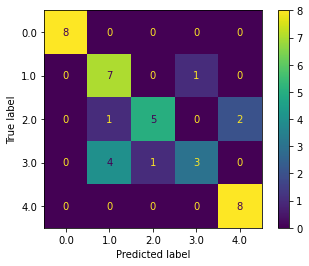

In [8]:
'''
1-3 Model Analysis: Here, we conduct a thorough analysis of the model including a *Confusion
Matrix* (on the validation set, which we get from spliting the training set into train/validation 
sets based on runs) and an *Example Examination* ()
'''
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

'''1-3-1 Confusion Matrix'''
# Split training data into train/validation sets according to runs
# Note: (The data is organized into eight runs, in order, with each run repeating 
# the same 20 music trials.)
train_x, train_y = train_data[:120], train_labels[:120].flatten() # we get runs 1-6, or the first 120 rows
val_x, val_y = train_data[-40:], train_labels[-40:].flatten() # we get runs 7 & 8, or the last 40 rows

svm_random_search.fit(train_x, train_y) # retrain the model on runs 1-6, using the best hyperparameters (found in 1-1)
y_pred = svm_random_search.predict(val_x) # test model on runs 7 & 8

# show the confusion matrix
cm = confusion_matrix(val_y, y_pred, labels=svm_random_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_random_search.classes_)
disp.plot()
plt.show()

In [9]:
'''1-3-2 Example Examination'''
# Here, we get 4 validation samples where the model fails to classify
wrong_predictions = np.where(y_pred != val_y)[0] # indecies where elements are not the same
select_4 = wrong_predictions[-4:] # take last 4 incorrect predictions

#print 4 incorrect validation samples:
print(f"Sample {select_4[0]}: [True_Label: {val_y[select_4[0]]}, Pred_Label: {y_pred[select_4[0]]}]")
print(f"Sample {select_4[1]}: [True_Label: {val_y[select_4[1]]}, Pred_Label: {y_pred[select_4[1]]}]")
print(f"Sample {select_4[2]}: [True_Label: {val_y[select_4[2]]}, Pred_Label: {y_pred[select_4[2]]}]")
print(f"Sample {select_4[3]}: [True_Label: {val_y[select_4[3]]}, Pred_Label: {y_pred[select_4[3]]}]")

Sample 30: [True_Label: 2.0, Pred_Label: 4.0]
Sample 31: [True_Label: 2.0, Pred_Label: 4.0]
Sample 34: [True_Label: 3.0, Pred_Label: 1.0]
Sample 35: [True_Label: 3.0, Pred_Label: 1.0]


We know that the following labels correspond to the following music genres:
    0=Ambient Music, 
    1=Country Music, 
    2=Heavy Metal,
    3=Rock 'n Roll,
    4=Classical Symphonic.
   
Looking at the Confusion Matrix, we can see that we predicted a person was listening to Classical Symphonic (pred = 4.0) when really they were listening to Heavy Metal (true = 2.0) 2 times, and that a person was listening to Country Music (pred = 1.0) when really they were listening to Rock 'n Roll (true = 3.0) 4 times. From the perspective of human brain data and music genre similarily, we could say that Country Music activates similar parts of the brain that Rock 'n Roll does, and same for Classical Symphonic and Heavy Metal.